<a href="https://colab.research.google.com/github/osamanoor17/cartoon-image-matcher/blob/main/cartoon_image_matcher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cartoon image detection system

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
Best Match: /content/drive/MyDrive/cartoons/Mickey-Mouse.webp with similarity: 1.0000


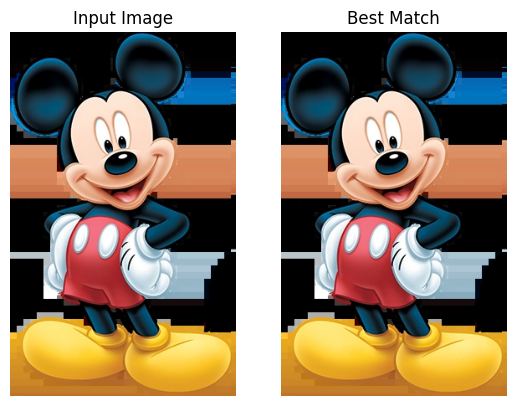

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import drive
import matplotlib.pyplot as plt

# Step 1: Google Drive Mount
drive.mount('/content/drive')

# Step 2: Define Paths
FOLDER_PATH = "/content/drive/MyDrive/cartoons"  # data path
INPUT_IMAGE_PATH = "/content/drive/MyDrive/cartoons/Mickey-Mouse.webp"  # matching image path

# Step 3: Load Pre-trained Model (VGG16)
base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=tf.keras.layers.GlobalAveragePooling2D()(base_model.output))

# Function to extract features from an image
def extract_features(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))  # Resize to match VGG16 input size
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = preprocess_input(img)  # Preprocess for VGG16
    features = model.predict(img)  # Extract features
    return features.flatten()

# Step 4: Extract Features from Input Image
input_features = extract_features(INPUT_IMAGE_PATH)

# Step 5: Extract Features from Folder Images & Compare
best_match = None
highest_similarity = -1
matched_image_path = None

for filename in os.listdir(FOLDER_PATH):
    file_path = os.path.join(FOLDER_PATH, filename)
    if filename.endswith((".jpg", ".png", ".webp")):
        folder_image_features = extract_features(file_path)
        similarity = cosine_similarity([input_features], [folder_image_features])[0][0]

        if similarity > highest_similarity:
            highest_similarity = similarity
            matched_image_path = file_path

# Step 6: Show Results
if matched_image_path:
    print(f"Best Match: {matched_image_path} with similarity: {highest_similarity:.4f}")

    # Display Images
    input_img = cv2.imread(INPUT_IMAGE_PATH)
    matched_img = cv2.imread(matched_image_path)

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB))
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
    plt.title("Best Match")
    plt.axis("off")

    plt.show()
else:
    print("No similar image found.")


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
import gradio as gr
from google.colab import drive
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Set Correct Folder Path for Dataset
FOLDER_PATH = "/content/drive/MyDrive/cartoons"  #my dataset path

# Step 3: Load Pre-trained Model (VGG16)
base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=tf.keras.layers.GlobalAveragePooling2D()(base_model.output))

# this is the fuction from where the user extracts the images
def extract_features(image):
    img = image.resize((224, 224))
    img = np.array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    features = model.predict(img)
    return features.flatten()

# this is the func to find the best match
def find_best_match(input_image, folder_path):
    input_features = extract_features(input_image)

    best_match = None
    highest_similarity = -1
    matched_image_path = None

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.endswith(('.jpg', '.png', '.webp')):
            folder_img = Image.open(file_path).convert('RGB')
            folder_features = extract_features(folder_img)
            similarity = cosine_similarity([input_features], [folder_features])[0][0]

            if similarity > highest_similarity:
                highest_similarity = similarity
                matched_image_path = file_path

    if matched_image_path:
        return matched_image_path, highest_similarity
    else:
        return None, 0

# UI Func of gardio
def match_image(uploaded_image):
    matched_image_path, similarity = find_best_match(uploaded_image, FOLDER_PATH)

    if matched_image_path:
        matched_image = Image.open(matched_image_path)
        return uploaded_image, matched_image, f"Similarity: {similarity:.4f}"
    else:
        return uploaded_image, None, "No similar image found."


iface = gr.Interface(
    fn=match_image,
    inputs=gr.Image(type="pil"),
    outputs=[gr.Image(type="pil"), gr.Image(type="pil"), gr.Text()],
    title="Cartoon Image Matcher",
    description="Upload an image to find the closest match in the dataset stored on Google Drive."
)
# running gardio
iface.launch(share=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://03a7ae9bf557377d09.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
